In [ ]:
# After taking care the libraries are installed (everything working to the current version: 01.03.2023) 
# and to properly log in to the IBM services...

In [ ]:
#Installers

!pip install pylatexenc
!pip install qutip
!pip install --upgrade qiskit
!pip install qiskit-ibm-runtime

!pip install jupyter scipy

!pip install mapomatic

!pip install qiskit_experiments

In [ ]:
########################################################
#Activation of IBMQ account down here!
########################################################

YOUR_API_TOKEN = 

YOUR_API_URL =       # tipically 'https://auth.quantum-computing.ibm.com/api' or 'https://auth.de.quantum-computing.ibm.com/api'

IBMQ.enable_account(YOUR_API_TOKEN,YOUR_API_URL)
provider = IBMQ.get_provider()

service = QiskitRuntimeService(channel='ibm_quantum',token=YOUR_API_TOKEN,url=YOUR_API_URL)

In [ ]:
#... run all the cells below in order to retrieve one example dynamics shown in the paper (thermal evolution with |1> initial state)
#Skipping only the one marked as being to save data locally for plotting

In [1]:
# Needed for functions
from copy import deepcopy

# Import Qiskit classes
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ
from qiskit.result import LocalReadoutMitigator, Counts
#from qiskit.providers.aer import noise, AerSimulator
from qiskit.compiler import assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.tools.visualization import plot_histogram
from qiskit.tools import job_monitor

# Auxiliary methods
from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate

from qiskit.quantum_info import partial_trace, DensityMatrix

from scipy.linalg import eig, sqrtm

##

from qutip import*
import numpy as np
import scipy as sy
import time
import random as random
from timeit import default_timer as timer
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from scipy.integrate import odeint, complex_ode, ode
import mapomatic as mm

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session, Options

In [2]:
#Optional code for available backends list

def print_backend_info(backend):
    print(backend.name(), end=': ')
    print('simulator: ' + str(backend.configuration().simulator), end=', ')
    print(str(backend.configuration().n_qubits) + ' qubits', end=', ')
    print(str(backend.status().pending_jobs) + ' jobs', end=', ')
    print(backend.status().status_msg, end=', ')
    if 'runtime' in backend.configuration().input_allowed:
        print("supports Runtime: yes")
    else:
        print("supports Runtime: no")

print("Provider:",provider)
print("Infos for available backends:")
for backend in provider.backends():
    print_backend_info(backend)

Provider: <AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
Infos for available backends:
ibmq_qasm_simulator: simulator: True, 32 qubits, 2 jobs, active, supports Runtime: yes
ibmq_lima: simulator: False, 5 qubits, 24 jobs, active, supports Runtime: yes
ibmq_belem: simulator: False, 5 qubits, 18 jobs, active, supports Runtime: yes
ibmq_quito: simulator: False, 5 qubits, 13 jobs, active, supports Runtime: yes
simulator_statevector: simulator: True, 32 qubits, 2 jobs, active, supports Runtime: yes
simulator_mps: simulator: True, 100 qubits, 2 jobs, active, supports Runtime: yes
simulator_extended_stabilizer: simulator: True, 63 qubits, 2 jobs, active, supports Runtime: yes
simulator_stabilizer: simulator: True, 5000 qubits, 2 jobs, active, supports Runtime: yes
ibmq_jakarta: simulator: False, 7 qubits, 101 jobs, active, supports Runtime: yes
ibmq_manila: simulator: False, 5 qubits, 133 jobs, active, supports Runtime: yes
ibm_lagos: simulator: False, 7 qubits, 65 jobs

In [10]:
#Defining the backend among the above liste ones
#ehningen = provider.get_backend('ibmq_ehningen')
lima = provider.get_backend('ibmq_lima')

In [11]:
def mu_cont(tlist,args): # compute the continuous part of the martingale evolution
    s=np.ones(len(tlist))
    ss=0
    for jj in range(1,len(tlist)):
        # We  compute the time integral for every interval and sum them together
        ss +=sy.integrate.quad(lambda t: -Martingale_Weight1(t,args)-Martingale_Weight2(t,args),tlist[jj-1], tlist[jj])[0]
        s[jj] = np.exp(ss)
    return s

def calc(t,sig,args): #compute individual jumps on the martingale
    if sig==0:
        s = 1 + Martingale_Weight1(t,args) / RateDown(t, args)**2
    elif sig==1:
        s = 1 + Martingale_Weight1(t,args) / RateUp(t, args)**2
    elif sig==2:
        s = 1 + Martingale_Weight2(t,args) / RateMinus(t, args)**2
    elif sig==3:
        s = 1 + Martingale_Weight2(t,args) / RatePlus(t, args)**2
    else:
        s = 1 
    return s

def mu_jump(J_list,J_which,args): #Function to compute the jump contributions to the martingale
    #Compute a vector with factors due to jumps
    s = np.zeros(len(J_list))
    for j in range(0,len(J_list)):
        s[j] = calc(J_list[j], J_which[j], args)
    
    #The vector s may contain several jumps that happened during the same time interval [tlist[j-1],tlist[j]]. All jumps in this time interval should be accounted for at time tlist[j].
    #The vector S will be the actual output, where this is taken into account.
    index = np.zeros(len(J_list))
    S = np.ones(len(tlist))
    for jj in range(0,len(J_list)):
        #Index contains the closest time in tlist to which the jump happened. however if t_jump>tlist[index[jj]] we need to shift the index to jj+1 
        index[jj] = np.argmin(np.abs(tlist-J_list[jj]))
        if tlist[index[jj].astype(int)] - J_list[jj] <0:
            index[jj] += 1
    #Combine all elememts s to the right places index in S
    for j in range(0,len(index)):
            S[index[j].astype(int):] *= s[j]
    return S


def State_Calc(MC,ntraj):
    Mu = mu_cont(tlist,None)
    lalaa=0
    StatePlus = np.zeros([2,2,ntraj],dtype = 'complex')
    StateMinus = np.zeros([2,2,ntraj],dtype = 'complex')
    for j in range(0,ntraj):
        lala = mu_jump(MC.col_times[j],MC.col_which[j],None)[jj] * Mu[jj]
        lalaa += lala/ntraj
        if lala > 0:
            StatePlus[:,:,j] = lala * np.outer(MC.states[j][jj],MC.states[j][jj].dag())
        else: 
            StateMinus[:,:,j] = -lala * np.outer(MC.states[j][jj],MC.states[j][jj].dag())
    StatePlus = StatePlus/lalaa
    StateMinus = StateMinus/lalaa
    return [StatePlus,StateMinus]

#References:
#[1] C. King and M.B. Ruskai. Minimal entropy of states emerging from noisy quantum channels. IEEE Trans- actions on Information Theory, 47(1):192–209, 2001.
def CPmap(TT,vec):  
                    #Input: TT, a 4x4 matrix which represents a linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
                    #Input: v, vec dimensional vector  
                    #Output: the state after applying the linear map as a 2x2 matrix
    vec1 = np.dot(TT,vec)
    return vec1[0]*np.eye(2)+vec1[1]*sigmax()+vec1[2]*sigmay()+vec1[3]*sigmaz()

def Tmatrix(Map):
                    #Input: a linear map acting on a qubit in the superoperator representation (i.e. as a 4x4 matrix using qutip functions)
                    #Output: TT a 4x4 matrix which represents a linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
    IdM = Qobj(vector_to_operator(Map*operator_to_vector(qeye(2))))
    sigmaxM = Qobj(vector_to_operator(Map*operator_to_vector(sigmax())))
    sigmayM = Qobj(vector_to_operator(Map*operator_to_vector(sigmay())))
    sigmazM = Qobj(vector_to_operator(Map*operator_to_vector(sigmaz())))
    TT = 1/2*np.array([[(IdM).tr(), (sigmaxM).tr(), (sigmayM).tr(), (sigmazM).tr()],\
                  [(sigmax()*IdM).tr(),(sigmax()*sigmaxM).tr(), (sigmax()*sigmayM).tr(), (sigmax()*sigmazM).tr()],\
                  [(sigmay()*IdM).tr(),(sigmay()*sigmaxM).tr(), (sigmay()*sigmayM).tr(), (sigmay()*sigmazM).tr()],\
                  [(sigmaz()*IdM).tr(),(sigmaz()*sigmaxM).tr(), (sigmaz()*sigmayM).tr(), (sigmaz()*sigmazM).tr()]])
    return TT

def ChoiMatrix(TT):
                    #Input TT, a 4x4 matrix which represents a linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
                    #Output: The Choi repersentation of the linear qubit map L which corresponds to TT (i.e. \sum_ij E_ij L(E_ij))
    Choi=np.zeros([4,4],dtype = complex)
    Choi[0:2,0:2] = CPmap(TT,np.array([1/2,0,0,1/2]))
    Choi[2:5,0:2] = CPmap(TT,np.array([0,1/2,-1j/2,0]))
    Choi[0:2,2:5] = CPmap(TT,np.array([0,1/2,1j/2,0]))
    Choi[2:5,2:5] = CPmap(TT,np.array([1/2,0,0,-1/2]))
    return Choi

def PosAndNegChoi(Choi):
    #u, s, vh = np.linalg.svd(Choi)
    #ChoiP = (u *s.clip(min=0)) @ vh 
    #ChoiM = (u *s.clip(max=0)) @ vh 
    s, v = np.linalg.eig(Choi)
    AAp=0 
    AAm=0 
    for jj in range(0,4):
        #AAp += max(0,np.real(s[jj])) *np.outer(v[:,jj], np.conjugate(v[:,jj])) 
        #AAm += max(0,-np.real(s[jj])) *np.outer(v[:,jj], np.conjugate(v[:,jj]))  
        AAp += max(0,np.real(s[jj])) *np.outer(v[:,jj], np.conjugate(v[:,jj])) 
        AAm += max(0,-np.real(s[jj])) *np.outer(v[:,jj], np.conjugate(v[:,jj])) 
    #some condition for numerical stability
    if np.sum(np.abs(AAm)) != 0:
        for jj in range(0,4):
            AAp += 0.01 *np.outer(v[:,jj], np.conjugate(v[:,jj])) 
            AAm += 0.01 *np.outer(v[:,jj], np.conjugate(v[:,jj])) 
    return AAp, AAm

def ChoiToTmatrix(Choi):
                    #Input: Choi matrix representation of a linear qubit map
                    #Output: TT, a 4x4 matrix which represents a linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
    TT=np.zeros([4,4],dtype = complex)
    IdM = Qobj(Choi[0:2,0:2]+Choi[2:5,2:5])
    sigmaxM = Qobj(Choi[2:5,0:2]+Choi[0:2,2:5])
    sigmayM = Qobj(1j*Choi[2:5,0:2]-1j*Choi[0:2,2:5])
    sigmazM = Qobj(Choi[0:2,0:2] - Choi[2:5,2:5])
    TT = 1/2*np.array([[(IdM).tr(), (sigmaxM).tr(), (sigmayM).tr(), (sigmazM).tr()],\
                  [(sigmax()*IdM).tr(),(sigmax()*sigmaxM).tr(), (sigmax()*sigmayM).tr(), (sigmax()*sigmazM).tr()],\
                  [(sigmay()*IdM).tr(),(sigmay()*sigmaxM).tr(), (sigmay()*sigmayM).tr(), (sigmay()*sigmazM).tr()],\
                  [(sigmaz()*IdM).tr(),(sigmaz()*sigmaxM).tr(), (sigmaz()*sigmayM).tr(), (sigmaz()*sigmazM).tr()]])
    return TT

def AdjointChoiToChoi(AChoi):
                    #Input: Choi matrix repraboutesentation of a linear qubit map
                    #Output: Choi matrix representation of the adjoint of the linear qubit map (formula: eq. (25) of [1])            
    U23 = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    Choi = np.conjugate(np.dot(U23,np.dot(AChoi,U23)))
    return Choi


def RotToUnitary(rot):
                    #Input: 3x3 rotation matrix representing a rotation on the Bloch sphere
                    #Output: 2x2 Unitary matrix representation of the rotation
    r = R.from_matrix(rot)
    v = r.as_rotvec()
    U = (-1j/2*(v[0]*sigmax()+v[1]*sigmay()+v[2]*sigmaz())).expm()
    return U
def D_Matrix(TT, epsilon = 0.01): #We have an input completely positive map L (represented by TTminusD) and we look for a matrix D
                                       # such that L^\dagger(1) + D^2 = (max eigenvalue(L^\dagger(1)) + epsilon)*1  
                    #Input: TT, a 4x4 matrix which represents a linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
                    #For our work, TT corresponds to the L_- in L = L_+ - L_-
                    #epsilon, some small number for numerical stability. 
                    #Output: Matt, a 4x4 matrix which represents the linear qubit map in the 1, sigma_x,y,z basis (i.e. on the bloch sphere)
                    #for the operation D \rho D
                    #max(AAA.eigenenergies()+epsilon), normalisation factor for the map
    AAA = CPmap(TT,np.array([1,0,0,0]))
    D = Qobj(sy.linalg.sqrtm(max(AAA.eigenenergies()+epsilon)*np.eye(2)-AAA))
    Matt = np.real(Tmatrix(sprepost(D,D)))
    return Matt, max(AAA.eigenenergies()+epsilon)

def ExtremalMaps(TT):
    Choi = ChoiMatrix(TT)
    Amat = Choi[0:2,0:2]
    Amat1 = Choi[2:4,2:4]
    Choi1 = ChoiMatrix(TT)
    Choi2 = ChoiMatrix(TT)
    
    UU = np.dot(np.dot(np.linalg.inv(sy.linalg.sqrtm(Amat)),Choi[0:2,2:4]),np.linalg.inv(sy.linalg.sqrtm(Amat1)))
    u, s, vh = np.linalg.svd(UU)
    s =np.round(s,5)
    
    DiagMat1 = np.array([[np.exp(1j*np.arccos(s[0])),0],[0,np.exp(1j*np.arccos(s[1]))]])
    DiagMat2 = np.array([[np.exp(-1j*np.arccos(s[0])),0],[0,np.exp(-1j*np.arccos(s[1]))]])
    
    Choi1[0:2,2:4] =  np.dot(sy.linalg.sqrtm(Amat),np.dot(u,np.dot(DiagMat1,np.dot(vh,sy.linalg.sqrtm(Amat1)))))
    Choi1[2:4,0:2] =  np.dot(sy.linalg.sqrtm(Amat1),np.dot(np.conjugate(vh.transpose()),\
                                                           np.dot(DiagMat2,np.dot(np.conjugate(u.transpose()),sy.linalg.sqrtm(Amat)))))
    
    Choi2[0:2,2:4] =  np.dot(sy.linalg.sqrtm(Amat),np.dot(u,np.dot(DiagMat2,np.dot(vh,sy.linalg.sqrtm(Amat1)))))
    Choi2[2:4,0:2] =  np.dot(sy.linalg.sqrtm(Amat1),np.dot(np.conjugate(vh.transpose()),\
                                                           np.dot(DiagMat1,np.dot(np.conjugate(u.transpose()),sy.linalg.sqrtm(Amat)))))
    return [Choi1, Choi2]

def KrausOps(nu,mu):
                    #Input: 2 angles
                    #Output: 2 qubit Kraus operators (2x2 matrices) defined as eq. (18) in [1]
    Kraus1 = Qobj(np.array([[np.cos((mu-nu)/2),0],[0,np.cos((mu+nu)/2)]]))
    Kraus2 = Qobj(np.array([[0,np.sin((mu+nu)/2)],[np.sin((mu-nu)/2),0]]))
    return Kraus1, Kraus2, nu, mu

def onemax(val):
    if np.real(val) >= 1:
        return 0.999
    else:
        return val

def KrausAndRotations(Choi):
    aaaa = ChoiToTmatrix(AdjointChoiToChoi(Choi))[1:4,1:4]
    uu, ss, vvh = np.linalg.svd(aaaa, full_matrices=True)
    U1 = RotToUnitary(np.linalg.det(uu)*uu)
    U2 = RotToUnitary(np.linalg.det(vvh)*vvh)
    #sigma = np.real(np.round(np.real(np.sin(np.arccos(np.linalg.det(uu)*np.linalg.det(vvh)*ss[0]))*np.sin(np.arccos(np.linalg.det(uu)*np.linalg.det(vvh)*ss[1])))\
    #         /np.dot(np.linalg.inv(np.linalg.det(uu)*uu),ChoiToTmatrix(AdjointChoiToChoi(Choi))[1:4,0])[2]))
    #if np.real(np.dot(np.linalg.inv(np.linalg.det(uu)*uu),ChoiToTmatrix(AdjointChoiToChoi(Choi))[1:4,0])[2])<0.0001:
    #    sigma = 1
    
    ang1,ang2,ang3 = np.linalg.det(uu)*np.linalg.det(vvh)*ss[0], np.linalg.det(uu)*np.linalg.det(vvh)*ss[0], np.linalg.det(uu)*np.linalg.det(vvh)*ss[1]
    ang1,ang2,ang3 = onemax(ang1),onemax(ang2),onemax(ang3)
    
    
    sigma = np.sign(np.real(np.sin(np.arccos(ang1))*np.sin(np.arccos(ang3))))\
            *np.sign(np.real(np.dot(np.linalg.inv(np.linalg.det(uu)*uu),ChoiToTmatrix(AdjointChoiToChoi(Choi))[1:4,0])[2]))
    if sigma ==0:
        sigma = 1
    test = np.real(np.dot(np.linalg.inv(np.linalg.det(uu)*uu),ChoiToTmatrix(AdjointChoiToChoi(Choi))[1:4,0])[2])
        
    theta1 = (sigma+1)/2*np.arccos(np.real(ang1)) + (-sigma+1)/2*(2*np.pi -np.arccos(np.real(ang2)))
    #theta1 = np.arccos(np.linalg.det(uu)*np.linalg.det(vvh)*ss[0]) + (-sigma+1)/2*(2*np.pi -np.arccos(np.linalg.det(uu)*np.linalg.det(vvh)*ss[0]))
    theta2 = np.arccos(np.real(ang3))
    Kraus1, Kraus2,nu, mu = KrausOps(theta1,theta2)
    
    #print('val1 = ', np.linalg.det(uu)*np.linalg.det(vvh)*ss[0],', val2 = ',np.linalg.det(uu)*np.linalg.det(vvh)*ss[0],', val3 = ',np.linalg.det(uu)*np.linalg.det(vvh)*ss[1])
    #print('ang1 = ',ang1,', ang2 = ',ang2,', ang3 = ',ang3)
    #print('theta1 = ',theta1,', theta2 = ',theta2)
    #print('theta1_1 = ',np.arccos(np.real(ang1)),', theta1_2 = ',-np.arccos(np.real(ang2)))
    #print('eccazzo: ', (sigma+1)/2*np.arccos(np.real(ang1)), ', eccazzo2: ', (-sigma+1)/2*(2*np.pi -np.arccos(np.real(ang2))))
    #print('sigma = ', sigma)
    
    return Kraus1, Kraus2, U1, U2, np.real(mu), np.real(nu), sigma

def measurement_layout(circuit):
    """
    Parameters:
        circuit (QuantumCircuit): Input Qiskit QuantumCircuit.

    Returns:
        list: measured qubits, in the same order as corresponding classical bits
    """
    active_qubits = list(range(circuit.num_qubits))
    active_cbits = list(range(circuit.num_clbits))

    # Map registers to ints
    qint_map = {}
    for idx, qq in enumerate(circuit.qubits):
        qint_map[qq] = idx

    cint_map = {}
    for idx, qq in enumerate(circuit.clbits):
        cint_map[qq] = idx

    print('till here fine')
    # Find final measurements starting in back
    qmap = []
    cmap = []
    print('here?')
    for item in circuit._data[::-1]:
        if item[0].name == "measure":
            cbit = cint_map[item[2][0]]
            qbit = qint_map[item[1][0]]
            print('till here fine')
            if cbit in active_cbits and qbit in active_qubits:
                qmap.append(qbit)
                cmap.append(cbit)
                print('till here fine again')
                active_cbits.remove(cbit)
                active_qubits.remove(qbit)
        elif item[0].name != "barrier":
            for qq in item[1]:
                _temp_qubit = qint_map[qq]
                if _temp_qubit in active_qubits:
                    active_qubits.remove(_temp_qubit)

        if not active_cbits or not active_qubits:
            break
    mapping = {}
    if cmap and qmap:
        for idx, qubit in enumerate(qmap):
            mapping[cmap[idx]] = qubit 
            
    return [mapping[i] for i in range(len(mapping))]

In [12]:
#Quantum State Recovery from thermalisation

ntraj = 10000# number of MC trajectories\
tf=1
ti=0
ti2 = 20
ttlist = np.linspace(0,tf,101)
tlist = ttlist[ti:]
tlist2 = ttlist[ti2:]
#tlist = ttlist
Del=9
lam=10
gam0=1
beta = 1
om = 1
s = 2*gam0*np.exp(beta*om)

#Rates for normal evolution
def RateUp(t, args):  # coefficient function
    #return np.sqrt(np.exp(-t**2)*(-np.sin(2*np.pi*t)**2)+3.5)
    return gam0
def RateDown(t, args):  # coefficient function
    return gam0*np.exp(beta*om)
def RatePlus(t, args):  # coefficient function
    s = 0
    return s
def RateMinus(t, args):  # coefficient function
    s = 0
    return s


def Martingale_Weight1(t,args):
    return s
def Martingale_Weight2(t,args):
    ss = 0
    return ss
    

#Rates for backward evolution
def RateUpMart(t, args):  # coefficient function
    return -gam0
def RateDownMart(t, args):  # coefficient function
    return -gam0*np.exp(beta*om)
def RatePlusMart(t, args):  # coefficient function
    s = 0
    return s
def RateMinusMart(t, args):  # coefficient function
    s = 0
    return s

#Observables

#Hamiltonian for second examle
H=sigmaz()/2  # Simple oscillator Hamiltonian
HH=-sigmaz()/2  # Simple oscillator Hamiltonian

#Parameters
N=2
a0=destroy(N)
taum = (sigmaz()-1j*sigmay())/2
taup = (sigmaz()+1j*sigmay())/2
e_ops = [sigmap() * sigmam(), sigmam() * sigmap(), sigmax(), sigmay(), taup*taum]

# Non CP
dd_ops=[]
dd_ops.append([lindblad_dissipator(sigmam(),sigmam()),RateDownMart])
dd_ops.append([lindblad_dissipator(sigmap(),sigmap()),RateUpMart])
dd_ops.append([lindblad_dissipator((sigmaz()-1j*sigmay())/2,-(sigmaz()-1j*sigmay())/2), RateMinusMart])
dd_ops.append([lindblad_dissipator((sigmaz()+1j*sigmay())/2,-(sigmaz()+1j*sigmay())/2), RatePlusMart])

ddd_ops=[]
ddd_ops.append([lindblad_dissipator(sigmam(),sigmam()),RateDown])
ddd_ops.append([lindblad_dissipator(sigmap(),sigmap()),RateUp])
"""

# CP
dd_ops=[]
dd_ops.append([lindblad_dissipator(sigmam(),sigmam()),RateDown])
dd_ops.append([lindblad_dissipator(sigmap(),sigmap()),RateUp])
dd_ops.append([lindblad_dissipator((sigmaz()-1j*sigmay())/2,(sigmaz()-1j*sigmay())/2), RateMinus])
dd_ops.append([lindblad_dissipator((sigmaz()+1j*sigmay())/2,(sigmaz()+1j*sigmay())/2), RatePlus])

"""

MESol0State0 = mesolve(H, Qobj(np.array([1,0])), tlist, dd_ops)
MESol0State1 = mesolve(H, Qobj(np.array([0,1])), tlist, dd_ops)
MESol0State2 = mesolve(H, Qobj(np.array([1,1])/np.sqrt(2)), tlist, dd_ops)
MESol0State3 = mesolve(H, Qobj(np.array([-1,1])/np.sqrt(2)), tlist, dd_ops)
MESol0State4 = mesolve(H, Qobj(np.array([-1j,1])/np.sqrt(2)), tlist, dd_ops)
MESol0State5 = mesolve(H, Qobj(np.array([1j,1])/np.sqrt(2)), tlist, dd_ops)

MESol0State0_F = mesolve(HH, Qobj(np.array([1,0])), tlist2, ddd_ops)
MESol0State1_F = mesolve(HH, Qobj(np.array([0,1])), tlist2, ddd_ops)
MESol0State2_F = mesolve(HH, Qobj(np.array([1,1])/np.sqrt(2)), tlist2, ddd_ops)
MESol0State3_F = mesolve(HH, Qobj(np.array([-1,1])/np.sqrt(2)), tlist2, ddd_ops)
MESol0State4_F = mesolve(HH, Qobj(np.array([-1j,1])/np.sqrt(2)), tlist2, ddd_ops)
MESol0State5_F = mesolve(HH, Qobj(np.array([1j,1])/np.sqrt(2)), tlist2, ddd_ops)

MESol0StateEx = mesolve(H, Qobj(np.array([1,0])), tlist, dd_ops,e_ops)

In [13]:
#TTpm funcs

def TTpm(jj): #Collets your generation of variables

    Idx = Qobj(np.array(MESol0State2.states)[jj] + np.array(MESol0State3.states)[jj])
    Idy = Qobj(np.array(MESol0State4.states)[jj] + np.array(MESol0State5.states)[jj])
    Idz = Qobj(np.array(MESol0State0.states)[jj] + np.array(MESol0State1.states)[jj])
  
    sigmaxx = Qobj(np.array(MESol0State2.states)[jj] - np.array(MESol0State3.states)[jj])
    sigmayy = Qobj(np.array(MESol0State4.states)[jj] - np.array(MESol0State5.states)[jj])
    sigmazz = Qobj(np.array(MESol0State0.states)[jj] - np.array(MESol0State1.states)[jj])
   
    
    
    TT = 1/2*np.array([[(Idx).tr(), (sigmaxx).tr(), (sigmayy).tr(), (sigmazz).tr()],\
                    [(sigmax()*Idx).tr(),(sigmax()*sigmaxx).tr(), (sigmax()*sigmayy).tr(), (sigmax()*sigmazz).tr()],\
                    [(sigmay()*Idx).tr(),(sigmay()*sigmaxx).tr(), (sigmay()*sigmayy).tr(), (sigmay()*sigmazz).tr()],\
                    [(sigmaz()*Idx).tr(),(sigmaz()*sigmaxx).tr(), (sigmaz()*sigmayy).tr(), (sigmaz()*sigmazz).tr()]])
  
    Choi = ChoiMatrix(TT)
    TTplus = ChoiToTmatrix(PosAndNegChoi(Choi)[0])
    TTminus = ChoiToTmatrix(PosAndNegChoi(Choi)[1])
    TTplusD = TTplus.transpose()
    TTminusD = TTminus.transpose()

    return TTplus, TTminus, TTplusD, TTminusD    

def TTpm_F(jj): #Collets your generation of variables

    Idx = Qobj(np.array(MESol0State2_F.states)[jj] + np.array(MESol0State3_F.states)[jj])
    Idy = Qobj(np.array(MESol0State4_F.states)[jj] + np.array(MESol0State5_F.states)[jj])
    Idz = Qobj(np.array(MESol0State0_F.states)[jj] + np.array(MESol0State1_F.states)[jj])
  
    sigmaxx = Qobj(np.array(MESol0State2_F.states)[jj] - np.array(MESol0State3_F.states)[jj])
    sigmayy = Qobj(np.array(MESol0State4_F.states)[jj] - np.array(MESol0State5_F.states)[jj])
    sigmazz = Qobj(np.array(MESol0State0_F.states)[jj] - np.array(MESol0State1_F.states)[jj])
   
    
    
    TT = 1/2*np.array([[(Idx).tr(), (sigmaxx).tr(), (sigmayy).tr(), (sigmazz).tr()],\
                    [(sigmax()*Idx).tr(),(sigmax()*sigmaxx).tr(), (sigmax()*sigmayy).tr(), (sigmax()*sigmazz).tr()],\
                    [(sigmay()*Idx).tr(),(sigmay()*sigmaxx).tr(), (sigmay()*sigmayy).tr(), (sigmay()*sigmazz).tr()],\
                    [(sigmaz()*Idx).tr(),(sigmaz()*sigmaxx).tr(), (sigmaz()*sigmayy).tr(), (sigmaz()*sigmazz).tr()]])
  
    Choi = ChoiMatrix(TT)
    TTplus = ChoiToTmatrix(PosAndNegChoi(Choi)[0])
    TTminus = ChoiToTmatrix(PosAndNegChoi(Choi)[1])
    TTplusD = TTplus.transpose()
    TTminusD = TTminus.transpose()

    return TTplus, TTminus, TTplusD, TTminusD

def TTpm2(jj): #Collets your generation of variables

    Idx = Qobj(np.array(MESol0State22.states)[jj] + np.array(MESol0State32.states)[jj])
    Idy = Qobj(np.array(MESol0State42.states)[jj] + np.array(MESol0State52.states)[jj])
    Idz = Qobj(np.array(MESol0State02.states)[jj] + np.array(MESol0State12.states)[jj])
  
    sigmaxx = Qobj(np.array(MESol0State22.states)[jj] - np.array(MESol0State32.states)[jj])
    sigmayy = Qobj(np.array(MESol0State42.states)[jj] - np.array(MESol0State52.states)[jj])
    sigmazz = Qobj(np.array(MESol0State02.states)[jj] - np.array(MESol0State12.states)[jj])
   
    
    
    TT = 1/2*np.array([[(Idx).tr(), (sigmaxx).tr(), (sigmayy).tr(), (sigmazz).tr()],\
                    [(sigmax()*Idx).tr(),(sigmax()*sigmaxx).tr(), (sigmax()*sigmayy).tr(), (sigmax()*sigmazz).tr()],\
                    [(sigmay()*Idx).tr(),(sigmay()*sigmaxx).tr(), (sigmay()*sigmayy).tr(), (sigmay()*sigmazz).tr()],\
                    [(sigmaz()*Idx).tr(),(sigmaz()*sigmaxx).tr(), (sigmaz()*sigmayy).tr(), (sigmaz()*sigmazz).tr()]])
  
    Choi = ChoiMatrix(TT)
    TTplus = ChoiToTmatrix(PosAndNegChoi(Choi)[0])
    TTminus = ChoiToTmatrix(PosAndNegChoi(Choi)[1])
    TTplusD = TTplus.transpose()
    TTminusD = TTminus.transpose()

    return TTplus, TTminus, TTplusD, TTminusD   

In [14]:
#Mirko funcs

def QAlgo_creation(mu,nu,xg,UP11,UP12,simulation='yes',precirc='no'): #Takes the needed parameters (mu, nu, UP11, UP12) and creates the quantum circuit to run

    #Handling parameters
    alpha = (mu+nu)/2
    beta = (mu-nu)/2

    tgam1 = np.real(beta - alpha + np.pi/2)
    tgam2 = np.real(beta + alpha - np.pi/2)

    # We create the quantum circuit
    nQubits = 2
    nReg = 2

    q = QuantumRegister(nQubits, name='q')
    c = ClassicalRegister(nReg, name='c')

    system = [0]
    ancillae = [1]

    qc = QuantumCircuit(q)
    qc.add_register(c)

    s = system
    e = ancillae
    
    if xg == 'yes':
        qc.x(s)

    qc.unitary(UP12.full(),0),qc.ry(tgam1,e)
    qc.cx(s,e)
    qc.ry(tgam2,e)
    qc.measure(e, c[0])
    qc.cx(e,s)
    #qc.x(s).c_if(c[0], 1)
    qc.unitary(UP11.full(),0)    
    if precirc == 'no':      
      #qc.x(s)
      qc.measure(s, c[1])

    #if simulation == 'no':
      #trans_qc_list = transpile([qc]*20, backend, optimization_level=3)
      #cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
      #print("Number of CNOT gates:",cx_count)
      #best_idx = np.where(cx_count == np.min(cx_count))[0][0]
      #best_qc = trans_qc_list[best_idx] 
      #best_small_qc = mm.deflate_circuit(best_qc)
      #layouts = mm.matching_layouts(best_small_qc, backend)
      #mm.evaluate_layouts(best_small_qc, layouts, backend)
      #result = mm.best_overall_layout(best_small_qc, backend)
      #layout = result[0]
      #print("Best layout: qubits", layout,", expected total error:",result[2])
      #qc_transpiled = transpile(best_small_qc,backend,initial_layout=layout,optimization_level=0)

      #qc = transpile(qc, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)    

    return qc


def QAlgo_creation2(mu,nu,xg,UP11,UP12,backend,simulation='yes'): #Takes the needed parameters (mu, nu, UP11, UP12) and creates the quantum circuit to run

    #Handling parameters
    alpha = (mu+nu)/2
    beta = (mu-nu)/2

    tgam1 = np.real(beta - alpha + np.pi/2)
    tgam2 = np.real(beta + alpha - np.pi/2)

    # We create the quantum circuit
    nQubits = 2
    nReg = 2

    q = QuantumRegister(nQubits, name='q')
    c = ClassicalRegister(nReg, name='c')

    system = [0]
    ancillae = [1]

    qc = QuantumCircuit(q)
    qc.add_register(c)

    s = system
    e = ancillae
    
    if xg == 'yes':
        qc.x(s)

    qc.unitary(UP12.full(),0),qc.ry(tgam1,e)
    qc.cx(s,e)
    qc.ry(tgam2,e)
    qc.measure(e, c[0])
    qc.cx(e,s)
    #qc.x(s).c_if(c[0], 1)
    qc.unitary(UP11.full(),0)    
    qc.x(s)
    qc.measure(s, c[1])

    if simulation == 'no':
      trans_qc_list = transpile([qc]*20, backend, optimization_level=3)
      cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
      #print("Number of CNOT gates:",cx_count)
      best_idx = np.where(cx_count == np.min(cx_count))[0][0]
      best_qc = trans_qc_list[best_idx] 
      best_small_qc = mm.deflate_circuit(best_qc)
      layouts = mm.matching_layouts(best_small_qc, backend)
      mm.evaluate_layouts(best_small_qc, layouts, backend)
      result = mm.best_overall_layout(best_small_qc, backend)
      layout = result[0]
      #print("Best layout: qubits", layout,", expected total error:",result[2])
      qc_transpiled = transpile(best_small_qc,backend,initial_layout=layout,optimization_level=0)
      return qc_transpiled, layout
      #qc = transpile(qc, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)    

    return qc,0


def opt_circuit(qc,backend):
  trans_qc_list = transpile([qc]*20, backend, optimization_level=3)
  cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
  #print("Number of CNOT gates:",cx_count)
  best_idx = np.where(cx_count == np.min(cx_count))[0][0]
  best_qc = trans_qc_list[best_idx] 
  best_small_qc = mm.deflate_circuit(best_qc)
  layouts = mm.matching_layouts(best_small_qc, backend)
  mm.evaluate_layouts(best_small_qc, layouts, backend)
  result = mm.best_overall_layout(best_small_qc, backend)
  layout = result[0]
  #print("Best layout: qubits", layout,", expected total error:",result[2])
  qc_transpiled = transpile(best_small_qc,backend,initial_layout=layout,optimization_level=0)
  return [qc_transpiled, layout]


def get_results_CP_light(counts1,counts2): #Here I run the circuits for the CP case and then combine the countings to evaluate the dynamics of the system.

    try:
        elvn1 = counts1['00']
    except:
        elvn1 = 0
    try:
        zon1 = counts1['01']
    except:
        zon1 = 0
        
    try:
        elvn2 = counts2['00']
    except:
        elvn2 = 0
    try:
        zon2 = counts2['01']
    except:
        zon2 = 0

    mea1 = zon1 + elvn1
    mea2 = zon2 + elvn2
    measure = zon1 + zon2 + elvn1 + elvn2
    
    return measure/2


def get_results_CP_double(counts1,counts2): #Here I run the circuits for the CP case and then combine the countings to evaluate the dynamics of the system.

    try:
        elvn1 = counts1['000']
    except:
        elvn1 = 0
    try:
        elvn2 = counts1['001']
    except:
        elvn2 = 0
    try:
        elvn3 = counts1['010']
    except:
        elvn3 = 0
    try:
        elvn4 = counts1['011']
    except:
        elvn4 = 0

    try:
        elvn5 = counts2['000']
    except:
        elvn5 = 0
    try:
        elvn6 = counts2['001']
    except:
        elvn6 = 0
    try:
        elvn7 = counts2['010']
    except:
        elvn7 = 0
    try:
        elvn8 = counts2['011']
    except:
        elvn8 = 0

    mea1 = elvn1 + elvn2 + elvn3 + elvn4
    mea2 = elvn5 + elvn6 + elvn7 + elvn8

    measure = mea1 + mea2
    
    return measure/2


def get_results_NCP_light(counts1,counts2,counts3,counts4,lamb,nshots): #Here I run the circuits for the Non-CP case and then combine the countings to evaluate the dynamics of the system. This might be investigated better maybe?

    sh1 = int((nshots/2)*lamb/(1+2*lamb))
    sh2 = int(nshots/2-sh1)

    if sh1 != 0:
        try:
            elvn1 = counts1['00']
        except:
            elvn1 = 0
        try:
            zon1 = counts1['01']
        except:
            zon1 = 0


        try:
            elvn2 = counts2['00']
        except:
            elvn2 = 0
        try:
            zon2 = counts2['01']
        except:
            zon2 = 0
            
        mea1 = zon1 + elvn1
        mea2 = zon2 + elvn2
        measure1 = (zon1 + zon2 + elvn1 + elvn2)*sh1/nshots

    else: 
        measure1 = 0

    try:
        elvn3 = counts3['00']
    except:
        elvn3 = 0
    try:
        zon3 = counts3['01']
    except:
        zon3 = 0

    try:
        elvn4 = counts4['00']
    except:
        elvn4 = 0
    try:
        zon4 = counts4['01']
    except:
        zon4 = 0
        
    mea3 = zon3 + elvn3
    mea4 = zon4 + elvn4
    measure2 = (zon3 + zon4 + elvn3 + elvn4)*sh2/nshots    
    evalu = (measure2*(1+2*lamb) - measure1*(1+2*lamb))

    return evalu, lamb


def get_results_NCP_double(counts1,counts2,counts3,counts4,lamb,nshots): #Here I run the circuits for the Non-CP case and then combine the countings to evaluate the dynamics of the system. This might be investigated better maybe?

    sh1 = int((nshots/2)*lamb/(1+2*lamb))
    sh2 = int(nshots/2-sh1)

    if sh1 != 0:
        try:
            elvn1 = counts1['000']
        except:
            elvn1 = 0
        try:
            elvn2 = counts1['001']
        except:
            elvn2 = 0
        try:
            elvn3 = counts1['010']
        except:
            elvn3 = 0
        try:
            elvn4 = counts1['011']
        except:
            elvn4 = 0

        try:
            elvn5 = counts2['000']
        except:
            elvn5 = 0
        try:
            elvn6 = counts2['001']
        except:
            elvn6 = 0
        try:
            elvn7 = counts2['010']
        except:
            elvn7 = 0
        try:
            elvn8 = counts2['011']
        except:
            elvn8 = 0

        mea1 = elvn1 + elvn2 + elvn3 + elvn4
        mea2 = elvn5 + elvn6 + elvn7 + elvn8
        measure1 = (mea1 + mea2)*sh1/nshots

    else: 
        measure1 = 0

    try:
        alvn1 = counts3['000']
    except:
        alvn1 = 0
    try:
        alvn2 = counts3['001']
    except:
        alvn2 = 0
    try:
        alvn3 = counts3['010']
    except:
        alvn3 = 0
    try:
        alvn4 = counts3['011']
    except:
        alvn4 = 0

    try:
        alvn5 = counts4['000']
    except:
        alvn5 = 0
    try:
        alvn6 = counts4['001']
    except:
        alvn6 = 0
    try:
        alvn7 = counts4['010']
    except:
        alvn7 = 0
    try:
        alvn8 = counts4['011']
    except:
        alvn8 = 0

    mea3 = alvn1 + alvn2 + alvn3 + alvn4
    mea4 = alvn5 + alvn6 + alvn7 + alvn8
    measure2 = (mea3 + mea4)*sh2/nshots
    evalu = (measure2*(1+2*lamb) - measure1*(1+2*lamb))

    return evalu, lamb


def get_results_NCP_double_XY(counts1,counts2,counts3,counts4,lamb,nshots): #Here I run the circuits for the Non-CP case and then combine the countings to evaluate the dynamics of the system. This might be investigated better maybe?

    sh1 = int((nshots/2)*lamb/(1+2*lamb))
    sh2 = int(nshots/2-sh1)

    if sh1 != 0:
        try:
            elvn1 = counts1['000']
        except:
            elvn1 = 0
        try:
            elvn2 = counts1['001']
        except:
            elvn2 = 0
        try:
            elvn3 = counts1['010']
        except:
            elvn3 = 0
        try:
            elvn4 = counts1['011']
        except:
            elvn4 = 0
            
        try:
            el1 = counts1['100']
        except:
            el1 = 0
        try:
            el2 = counts1['101']
        except:
            el2 = 0
        try:
            el3 = counts1['110']
        except:
            el3 = 0
        try:
            el4 = counts1['111']
        except:
            el4 = 0

        try:
            elvn5 = counts2['000']
        except:
            elvn5 = 0
        try:
            elvn6 = counts2['001']
        except:
            elvn6 = 0
        try:
            elvn7 = counts2['010']
        except:
            elvn7 = 0
        try:
            elvn8 = counts2['011']
        except:
            elvn8 = 0
            
        try:
            el5 = counts2['100']
        except:
            el5 = 0
        try:
            el6 = counts2['101']
        except:
            el6 = 0
        try:
            el7 = counts2['110']
        except:
            el7 = 0
        try:
            el8 = counts2['111']
        except:
            el8 = 0

        mea1 = elvn1 + elvn2 + elvn3 + elvn4 - (el1 + el2 + el3 + el4)
        mea2 = elvn5 + elvn6 + elvn7 + elvn8 - (el5 + el6 + el7 + el8)
        measure1 = (mea1 + mea2)*sh1/nshots

    else: 
        measure1 = 0

    try:
        alvn1 = counts3['000']
    except:
        alvn1 = 0
    try:
        alvn2 = counts3['001']
    except:
        alvn2 = 0
    try:
        alvn3 = counts3['010']
    except:
        alvn3 = 0
    try:
        alvn4 = counts3['011']
    except:
        alvn4 = 0
        
    try:
        al1 = counts3['100']
    except:
        al1 = 0
    try:
        al2 = counts3['101']
    except:
        al2 = 0
    try:
        al3 = counts3['110']
    except:
        al3 = 0
    try:
        al4 = counts3['111']
    except:
        al4 = 0

    try:
        alvn5 = counts4['000']
    except:
        alvn5 = 0
    try:
        alvn6 = counts4['001']
    except:
        alvn6 = 0
    try:
        alvn7 = counts4['010']
    except:
        alvn7 = 0
    try:
        alvn8 = counts4['011']
    except:
        alvn8 = 0
        
    try:
        al5 = counts4['100']
    except:
        al5 = 0
    try:
        al6 = counts4['101']
    except:
        al6 = 0
    try:
        al7 = counts4['110']
    except:
        al7 = 0
    try:
        al8 = counts4['111']
    except:
        al8 = 0

    mea3 = alvn1 + alvn2 + alvn3 + alvn4 - (al1 + al2 + al3 + al4)
    mea4 = alvn5 + alvn6 + alvn7 + alvn8 - (al5 + al6 + al7 + al8)
    measure2 = (mea3 + mea4)*sh2/nshots
    evalu = (measure2*(1+2*lamb) - measure1*(1+2*lamb))

    return evalu, lamb


def extr_maps(TTminusD,TTplusD): #Just a small collection of your functions preparing the Non-CP dynamical runs

    #Calculate D to make maps norm preserving
    Matt, lamb = D_Matrix(TTminusD,0.01)

    #Calculate the extremal maps in the Choi representation
    [ChoiM1, ChoiM2] = ExtremalMaps((TTminusD+Matt)/lamb)
    [ChoiP1, ChoiP2] = ExtremalMaps((TTplusD+Matt)/(1+lamb))

    return ChoiM1, ChoiM2, ChoiP1, ChoiP2, lamb

def brechtlayout(tlist,Ran,tevol,name):
  
  if len(tevol)!=len(Ran):
    print('Ran and tevol have different sizes')
    return 1

  size = len(tevol)
  arr = np.ndarray((size,2))
  for i in range(size):
    arr[i,0] = tlist[Ran[i]]
    arr[i,1] = 1-tevol[i]

  np.savetxt('/content/drive/MyDrive/Colab Notebooks/'+name+'.txt', arr)


def brechtlayoutMult(tlist,Ran,tevol,name):
  
  #if len(tevol)!=len(Ran):
  #  print('Ran and tevol have different sizes')
  #  return 1

    size = len(tevol[0])
    arr = np.ndarray((10*size,2))
    for kap in range(10):
        for i in range(size):
            arr[kap*size + i,0] = tlist[Ran[i]]
            arr[kap*size + i,1] = tevol[kap][i]

    np.savetxt(name+'.txt', arr)
    
    
def fid_meas(rho1,rho2):
    
    appo = sqrtm(np.matmul(np.matmul(sqrtm(rho1),rho2),sqrtm(rho1))).trace().real
    
    return appo**2

def fid_meas2(rho1,rho2):
    
    appo = fid_meas(rho1,rho2)
    
    return (1-(np.abs(1-appo)))*100   

In [15]:
#MOVING FORWARD!

In [16]:
#Forward time evolution

simulation = 'yes' # 'yes' or 'no'
dynamics = 'thermal' # 'thermal' or 'non-mark'

xg = 'no'

Ran = [1,3,5,7,9,11,13,15,17,19,21]        #,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50,55,60,65,70      ,23,25,27,29,31
nshots = 10000
NCPindex = []
qcs = []
nshotss = []
lambs = []
backend = lima #Will come in play only flagging simulation = 'no'

layoutCP = 0
layoutNCP = 0

simulNum = 10

start_time = time.time()

for stat in range(simulNum):
    print("Now running run number ", stat+1)
    for kk in range(len(Ran)):

        jj = Ran[kk]

        if dynamics == 'non-mark':
          TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)
        if dynamics == 'thermal':
          TTplus, TTminus, TTplusD, TTminusD = TTpm_F(jj)

        if np.sum(np.abs(TTminus))<0.0000001:
            NCPindex.append('CP')
            [ChoiP1, ChoiP2] = ExtremalMaps(TTplusD-TTminusD)
            KrausP11, KrausP12, UP11, UP12, mu1, nu1, sigma1 = KrausAndRotations(ChoiP1) #K0, K1, Uphi, Udel / 1st extremal
            KrausP21, KrausP22, UP21, UP22, mu2, nu2, sigma2 = KrausAndRotations(ChoiP2) ##K0, K1, Uphi, Udel / 2nd extremal
            expectt = spre(sigmap()*sigmam())
            lamb = 0
            lambs.append(lamb)

            qc1 = QAlgo_creation(mu1,nu1,xg,UP11,UP12)
            qc2 = QAlgo_creation(mu2,nu2,xg,UP21,UP22)

            ##################################################################
            if simulation == 'no':
                [qc1,layoutCP],[qc2,layoutCP] = opt_circuit(qc1,backend),opt_circuit(qc2,backend)
            if simulation == 'yes':
                qc1 = transpile(qc1, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                qc2 = transpile(qc2, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
            ##################################################################        

            qcs.append(qc1),qcs.append(qc2)
            nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2))
            print(layoutCP, 'CP')

        else:
            NCPindex.append('NCP')
            ChoiM1, ChoiM2, ChoiP1, ChoiP2, lamb = extr_maps(TTminusD,TTplusD)
            lambs.append(lamb)

            #Compute the 4 pairs of Kraus operators 
            KrausM11, KrausM12, UM11, UM12, muM1, nuM1, sigma1 = KrausAndRotations(ChoiM1)
            KrausM21, KrausM22, UM21, UM22, muM2, nuM2, sigma2 = KrausAndRotations(ChoiM2)
            KrausP11, KrausP12, UP11, UP12, muP1, nuP1, sigma3 = KrausAndRotations(ChoiP1)
            KrausP21, KrausP22, UP21, UP22, muP2, nuP2, sigma4 = KrausAndRotations(ChoiP2)

            sh1 = int((nshots/2)*lamb/(1+2*lamb))
            sh2 = int(nshots/2-sh1)

            qc1 = QAlgo_creation(muM1,nuM1,xg,UM11,UM12)
            qc2 = QAlgo_creation(muM2,nuM2,xg,UM21,UM22)
            qc3 = QAlgo_creation(muP1,nuP1,xg,UP11,UP12)
            qc4 = QAlgo_creation(muP2,nuP2,xg,UP21,UP22)

            ##################################################################
            if simulation == 'no':
                [qc1,layoutNCP],[qc2,layoutNCP], [qc3,layoutNCP],[qc4,layoutNCP] = opt_circuit(qc1,backend),opt_circuit(qc2,backend), opt_circuit(qc3,backend),opt_circuit(qc4,backend)
            if simulation == 'yes':
                qc1 = transpile(qc1, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                qc2 = transpile(qc2, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                qc3 = transpile(qc3, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                qc4 = transpile(qc4, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
            ################################################################## 

            qcs.append(qc1),qcs.append(qc2),qcs.append(qc3),qcs.append(qc4)
            nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh2),nshotss.append(sh2)
            print(layoutNCP, 'NCP')

        print(kk)
print(time.time() - start_time, " seconds to run")


if simulation == 'yes':    
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    #resilience_settings = {"level":0}  
    circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist()
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_qasm_simulator" }) as sampler:
    #    # pass indices of circuits
    #    mitigated_probs = sampler(circuits=circlist,shots=nshots)
    #    mitigated_probs = mitigated_probs.quasi_dists

    with Session(service=service, backend = "ibmq_qasm_simulator"):
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        mitigated_probs = job.result().quasi_dists

        
elif simulation == 'no':
    start_time = time.time()

########################################################
  #qubitss = measurement_layout(qcs[0])
    if layoutNCP == 0:
        exp = LocalReadoutError(layoutCP)
    else:
        exp = LocalReadoutError(layoutNCP)
    
    exp.run_options.__dict__['shots']=10000
  
    print("RUNNING 1!")
    result = exp.run(backend)
    #print(result.assignment_matrix())
    #mitigator = LocalReadoutMitigator(assignment_matrices=result.assignment_matrix()) 
    mitigator = result.analysis_results(0).value
########################################################
      
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist() 
    #resilience_settings = {"level":0}
    samples_with_rem = None
    
    print("RUNNING 2!")
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_ehningen" }) as sampler:    # "ibmq_qasm_simulator", "ibm_geneva", "ibmq_toronto"
    #    # pass indices of circuits
    #    countings = sampler(circuits=circlist,shots=nshots)         
    with Session(service=service, backend = "ibmq_lima"):
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        countings = job.result().quasi_dists

        
    mitigated_probs = []
    for i in range(len(countings)):  
        mitigated_quasi_probs = mitigator.quasi_probabilities(countings[i].binary_probabilities()) #may be negative
        mitigated_probs.append(mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

Now running run number  1
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  2
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  3
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  4
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  5
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  6
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  7
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  8
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  9
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 CP
5
0 CP
6
0 CP
7
0 CP
8
0 CP
9
0 CP
10
Now running run number  10
0 CP
0
0 CP
1
0 CP
2
0 CP
3
0 CP
4
0 

In [17]:
xj = 0
tevolpre = np.zeros((simulNum,len(Ran)))

if simulation == 'yes':
    for kj in range(len(mitigated_probs)):
        mitigated_probs[kj] = mitigated_probs[kj].binary_probabilities()

for stat in range(simulNum):
    for kk in range(len(Ran)):
        if NCPindex[kk] == 'CP':
            tevolpre[stat,kk] = get_results_CP_light(mitigated_probs[xj],mitigated_probs[xj+1])
            xj = xj+2
            #print('CP')

        else:
            tevolpre[stat,kk],lamb = get_results_NCP_light(mitigated_probs[xj],mitigated_probs[xj+1],mitigated_probs[xj+2],mitigated_probs[xj+3],lambs[kk],nshots)
            xj = xj+4
            #print('NCP')
            
print('Done')

#np.savetxt('/content/drive/MyDrive/Colab Notebooks/tevol_startmiddle_normal2.gz', tevol)

Done


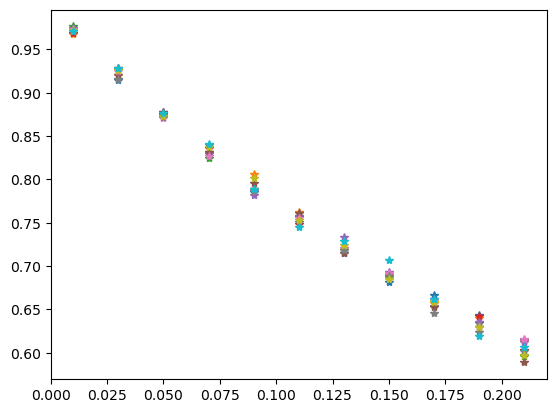

In [18]:
for i in range(simulNum):
    plt.plot(tlist[Ran],tevolpre[i],'*')

In [19]:
#SKIP!!!! Only for data saving in local and plotting

#brechtlayoutMult(tlist,Ran,tevolpre,'Thermal_1_CP')
#tttry = np.loadtxt('Thermal_1_CP.txt')

#tlistt = []
#tevoll = []

#for i in range(simulNum):
#    tlistt.append(tttry[i*len(tlist[Ran]):(i+1)*len(tlist[Ran]),0]) 
#    tevoll.append(tttry[i*len(tlist[Ran]):(i+1)*len(tlist[Ran]),1])
    
#tlistt = tlistt[0]
    
    
#for i in range(simulNum):
#    plt.plot(tlistt,tevoll[i],'*') 

In [20]:
#Fidelity measure code!!

In [21]:
#Backward evolution, with fidelity measure!

#Last changes: transpilation added to simulations too, as got needed; added binary probabilities property to the reading function, in case of simulation


sigy = [[1, -1j],[1, 1j]]/np.sqrt(2)
#circuit = QuantumCircuit(2)
#circuit.unitary(sigy, [0])

simulation = 'yes'
jj = 22
backend = lima
dynamics = 'thermal'

layoutCP = 0
layoutNCP = 0

if dynamics == 'non-mark':
  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)
if dynamics == 'thermal':
  TTplus, TTminus, TTplusD, TTminusD = TTpm_F(jj)

xg = 'no'

if np.sum(np.abs(TTminus))<0.0000001:
    [ChoiP1, ChoiP2] = ExtremalMaps(TTplusD-TTminusD)
    KrausP11, KrausP12, UP11, UP12, mu1, nu1, sigma1 = KrausAndRotations(ChoiP1) #K0, K1, Uphi, Udel / 1st extremal
    KrausP21, KrausP22, UP21, UP22, mu2, nu2, sigma2 = KrausAndRotations(ChoiP2) ##K0, K1, Uphi, Udel / 2nd extremal
    expectt = spre(sigmap()*sigmam())
    lamb = 0

    qc1 = QAlgo_creation(mu1,nu1,xg,UP11,UP12,simulation='yes',precirc='yes')
    qc2 = QAlgo_creation(mu2,nu2,xg,UP21,UP22,simulation='yes',precirc='yes')

else:
    print('Map is not CP')


Ran = [1,3,5,7,9,11,13,15,17,19,21]         #,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50,55,60,65,70
nshots = 10000
NCPindex = []
qcs = []
nshotss = []
lambs = []
simulNum = 10

xg = 'no'

for stat in range(simulNum):
    print("Now running run number ", stat+1)
    for kk in range(len(Ran)):

        jj = Ran[kk]

        #if dynamics == 'non-mark':
        #  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)
        #if dynamics == 'thermal':
        #  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)

        TTplus, TTminus, TTplusD, TTminusD = TTpm(jj) #TTpm in any case, 'cos we move backwards

        if np.sum(np.abs(TTminus))<0.0000001:
            NCPindex.append('CP')
            [ChoiP1, ChoiP2] = ExtremalMaps(TTplusD-TTminusD)
            KrausP11, KrausP12, UP11, UP12, mu1, nu1, sigma1 = KrausAndRotations(ChoiP1) #K0, K1, Uphi, Udel / 1st extremal
            KrausP21, KrausP22, UP21, UP22, mu2, nu2, sigma2 = KrausAndRotations(ChoiP2) ##K0, K1, Uphi, Udel / 2nd extremal
            expectt = spre(sigmap()*sigmam())
            lamb = 0
            lambs.append(lamb)

            qca = QAlgo_creation(mu1,nu1,xg,UP11,UP12,precirc='yes')
            qcb = QAlgo_creation(mu2,nu2,xg,UP21,UP22,precirc='yes')

            # We create the quantum circuits
            nQubits = 3
            nReg = 3

            q1a = QuantumRegister(nQubits, name='q1a')
            c1a = ClassicalRegister(nReg, name='c1a')
            q1b = QuantumRegister(nQubits, name='q1b')
            c1b = ClassicalRegister(nReg, name='c1b')
            q2a = QuantumRegister(nQubits, name='q2a')
            c2a = ClassicalRegister(nReg, name='c2a')
            q2b = QuantumRegister(nQubits, name='q2b')
            c2b = ClassicalRegister(nReg, name='c2b')

            qc1a = QuantumCircuit(q1a)
            qc1a.add_register(c1a)
            qc1b = QuantumCircuit(q1b)
            qc1b.add_register(c1b)
            qc2a = QuantumCircuit(q2a)
            qc2a.add_register(c2a)
            qc2b = QuantumCircuit(q2b)
            qc2b.add_register(c2b)

            qc1a.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1b.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2a.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2b.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)

            
            ##################################################################            
            if kk == len(Ran)-1:
                qc1ax = qc1a.copy()
                qc1bx = qc1b.copy()
                qc2ax = qc2a.copy()
                qc2bx = qc2b.copy()
                qc1ay = qc1a.copy()
                qc1by = qc1b.copy()
                qc2ay = qc2a.copy()
                qc2by = qc2b.copy()
                for ind in range(3):
                    qc1ax.h(ind)
                    qc1bx.h(ind)
                    qc2ax.h(ind)
                    qc2bx.h(ind)
                    qc1ay.unitary(sigy, [ind])
                    qc1by.unitary(sigy, [ind])
                    qc2ay.unitary(sigy, [ind])
                    qc2by.unitary(sigy, [ind])               
                qc1ax.measure(0, 2)
                qc1bx.measure(0, 2)
                qc2ax.measure(0, 2)
                qc2bx.measure(0, 2)
                qc1ay.measure(0, 2)
                qc1by.measure(0, 2)
                qc2ay.measure(0, 2)
                qc2by.measure(0, 2)
            ##################################################################
            
            qc1a.measure(0, 2)
            qc1b.measure(0, 2)
            qc2a.measure(0, 2)
            qc2b.measure(0, 2)
            
            
            
            ##################################################################
            if simulation == 'no':
              [qc1a,layoutCP],[qc1b,layoutCP],[qc2a,layoutCP],[qc2b,layoutCP] = opt_circuit(qc1a,backend),opt_circuit(qc1b,backend),opt_circuit(qc2a,backend),opt_circuit(qc2b,backend)
            if simulation == 'yes':
              qc1a = transpile(qc1a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1b = transpile(qc1b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc2a = transpile(qc2a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2b = transpile(qc2b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
            ##################################################################

            qcs.append(qc1a),qcs.append(qc1b),qcs.append(qc2a),qcs.append(qc2b)
            nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2))
            print(layoutCP, 'CP')
            
            if kk == len(Ran)-1:
                if simulation == 'no':
                  [qc1ax,layoutCP],[qc1bx,layoutCP],[qc2ax,layoutCP],[qc2bx,layoutCP] = opt_circuit(qc1ax,backend),opt_circuit(qc1bx,backend),opt_circuit(qc2ax,backend),opt_circuit(qc2bx,backend)
                  [qc1ay,layoutCP],[qc1by,layoutCP],[qc2ay,layoutCP],[qc2by,layoutCP] = opt_circuit(qc1ay,backend),opt_circuit(qc1by,backend),opt_circuit(qc2ay,backend),opt_circuit(qc2by,backend)
                if simulation == 'yes':
                  qc1ax = transpile(qc1ax, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1bx = transpile(qc1bx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2ax = transpile(qc2ax, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2bx = transpile(qc2bx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1ay = transpile(qc1ay, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1by = transpile(qc1by, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2ay = transpile(qc2ay, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2by = transpile(qc2by, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)

                qcs.append(qc1ax),qcs.append(qc1bx),qcs.append(qc2ax),qcs.append(qc2bx)
                qcs.append(qc1ay),qcs.append(qc1by),qcs.append(qc2ay),qcs.append(qc2by)

        else:
            NCPindex.append('NCP')
            ChoiM1, ChoiM2, ChoiP1, ChoiP2, lamb = extr_maps(TTminusD,TTplusD)
            lambs.append(lamb)

            #Compute the 4 pairs of Kraus operators 
            KrausM11, KrausM12, UM11, UM12, muM1, nuM1, sigma1 = KrausAndRotations(ChoiM1)
            KrausM21, KrausM22, UM21, UM22, muM2, nuM2, sigma2 = KrausAndRotations(ChoiM2)
            KrausP11, KrausP12, UP11, UP12, muP1, nuP1, sigma3 = KrausAndRotations(ChoiP1)
            KrausP21, KrausP22, UP21, UP22, muP2, nuP2, sigma4 = KrausAndRotations(ChoiP2)

            sh1 = int((nshots/2)*lamb/(1+2*lamb))
            sh2 = int(nshots/2-sh1)

            qca = QAlgo_creation(muM1,nuM1,xg,UM11,UM12,precirc='yes')
            qcb = QAlgo_creation(muM2,nuM2,xg,UM21,UM22,precirc='yes')
            qcc = QAlgo_creation(muP1,nuP1,xg,UP11,UP12,precirc='yes')
            qcd = QAlgo_creation(muP2,nuP2,xg,UP21,UP22,precirc='yes')

            # We create the quantum circuits
            nQubits = 3
            nReg = 3

            q1a = QuantumRegister(nQubits, name='q1a')
            c1a = ClassicalRegister(nReg, name='c1a')
            q1b = QuantumRegister(nQubits, name='q1b')
            c1b = ClassicalRegister(nReg, name='c1b')
            q1c = QuantumRegister(nQubits, name='q1c')
            c1c = ClassicalRegister(nReg, name='c1c')
            q1d = QuantumRegister(nQubits, name='q1d')
            c1d = ClassicalRegister(nReg, name='c1d')
            q2a = QuantumRegister(nQubits, name='q2a')
            c2a = ClassicalRegister(nReg, name='c2a')
            q2b = QuantumRegister(nQubits, name='q2b')
            c2b = ClassicalRegister(nReg, name='c2b')
            q2c = QuantumRegister(nQubits, name='q2c')
            c2c = ClassicalRegister(nReg, name='c2c')
            q2d = QuantumRegister(nQubits, name='q2d')
            c2d = ClassicalRegister(nReg, name='c2d')

            qc1a = QuantumCircuit(q1a)
            qc1a.add_register(c1a)
            qc1b = QuantumCircuit(q1b)
            qc1b.add_register(c1b)
            qc1c = QuantumCircuit(q1c)
            qc1c.add_register(c1c)
            qc1d = QuantumCircuit(q1d)
            qc1d.add_register(c1d)
            qc2a = QuantumCircuit(q2a)
            qc2a.add_register(c2a)
            qc2b = QuantumCircuit(q2b)
            qc2b.add_register(c2b)
            qc2c = QuantumCircuit(q2c)
            qc2c.add_register(c2c)
            qc2d = QuantumCircuit(q2d)
            qc2d.add_register(c2d)

            qc1a.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1b.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1c.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1c.compose(qcc, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1d.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1d.compose(qcd, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2a.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2b.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2c.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2c.compose(qcc, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2d.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2d.compose(qcd, qubits=[0, 2], clbits=[0, 2], inplace=True)
         
            ##################################################################            
            if kk == len(Ran)-1:
                qc1ax = qc1a.copy()
                qc1bx = qc1b.copy()
                qc2ax = qc2a.copy()
                qc2bx = qc2b.copy()
                qc1ay = qc1a.copy()
                qc1by = qc1b.copy()
                qc2ay = qc2a.copy()
                qc2by = qc2b.copy()
                qc1cx = qc1c.copy()
                qc1dx = qc1d.copy()
                qc2cx = qc2c.copy()
                qc2dx = qc2d.copy()
                qc1cy = qc1c.copy()
                qc1dy = qc1d.copy()
                qc2cy = qc2c.copy()
                qc2dy = qc2d.copy()
                for ind in range(3):
                    qc1ax.h(ind)
                    qc1bx.h(ind)
                    qc2ax.h(ind)
                    qc2bx.h(ind)
                    qc1ay.unitary(sigy, [ind])
                    qc1by.unitary(sigy, [ind])
                    qc2ay.unitary(sigy, [ind])
                    qc2by.unitary(sigy, [ind])   
                    qc1cx.h(ind)
                    qc1dx.h(ind)
                    qc2cx.h(ind)
                    qc2dx.h(ind)
                    qc1cy.unitary(sigy, [ind])
                    qc1dy.unitary(sigy, [ind])
                    qc2cy.unitary(sigy, [ind])
                    qc2dy.unitary(sigy, [ind])   
                qc1ax.measure(0, 2)
                qc1bx.measure(0, 2)
                qc2ax.measure(0, 2)
                qc2bx.measure(0, 2)
                qc1ay.measure(0, 2)
                qc1by.measure(0, 2)
                qc2ay.measure(0, 2)
                qc2by.measure(0, 2)
                qc1cx.measure(0, 2)
                qc1dx.measure(0, 2)
                qc2cx.measure(0, 2)
                qc2dx.measure(0, 2)
                qc1cy.measure(0, 2)
                qc1dy.measure(0, 2)
                qc2cy.measure(0, 2)
                qc2dy.measure(0, 2)
            ##################################################################            
            qc1a.measure(0, 2)
            qc1b.measure(0, 2)
            qc2a.measure(0, 2)
            qc2b.measure(0, 2) 
            qc1c.measure(0, 2)
            qc1d.measure(0, 2)
            qc2c.measure(0, 2)
            qc2d.measure(0, 2)           
            

            ##################################################################
            if simulation == 'no':  
              [qc1a,layoutNCP],[qc1b,layoutNCP],[qc1c,layoutNCP],[qc1d,layoutNCP] = opt_circuit(qc1a,backend),opt_circuit(qc1b,backend),opt_circuit(qc1c,backend),opt_circuit(qc1d,backend)
              [qc2a,layoutNCP],[qc2b,layoutNCP],[qc2c,layoutNCP],[qc2d,layoutNCP] = opt_circuit(qc2a,backend),opt_circuit(qc2b,backend),opt_circuit(qc2c,backend),opt_circuit(qc2d,backend)
            if simulation == 'yes':
              qc1a = transpile(qc1a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1b = transpile(qc1b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc1c = transpile(qc1c, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1d = transpile(qc1d, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc2a = transpile(qc2a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2b = transpile(qc2b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)        
              qc2c = transpile(qc2c, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2d = transpile(qc2d, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)  
            ##################################################################

            qcs.append(qc1a),qcs.append(qc1b),qcs.append(qc1c),qcs.append(qc1d),qcs.append(qc2a),qcs.append(qc2b),qcs.append(qc2c),qcs.append(qc2d)
            nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh2),nshotss.append(sh2),nshotss.append(sh2),nshotss.append(sh2)
            print(layoutNCP, 'NCP')
            
            
            if kk == len(Ran)-1:
                if simulation == 'no':
                  [qc1ax,layoutCP],[qc1bx,layoutCP],[qc2ax,layoutCP],[qc2bx,layoutCP] = opt_circuit(qc1ax,backend),opt_circuit(qc1bx,backend),opt_circuit(qc2ax,backend),opt_circuit(qc2bx,backend)
                  [qc1ay,layoutCP],[qc1by,layoutCP],[qc2ay,layoutCP],[qc2by,layoutCP] = opt_circuit(qc1ay,backend),opt_circuit(qc1by,backend),opt_circuit(qc2ay,backend),opt_circuit(qc2by,backend)
                  [qc1cx,layoutCP],[qc1dx,layoutCP],[qc2cx,layoutCP],[qc2dx,layoutCP] = opt_circuit(qc1cx,backend),opt_circuit(qc1dx,backend),opt_circuit(qc2cx,backend),opt_circuit(qc2dx,backend)
                  [qc1cy,layoutCP],[qc1dy,layoutCP],[qc2cy,layoutCP],[qc2dy,layoutCP] = opt_circuit(qc1cy,backend),opt_circuit(qc1dy,backend),opt_circuit(qc2cy,backend),opt_circuit(qc2dy,backend)
                if simulation == 'yes':
                  qc1ax = transpile(qc1ax, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1bx = transpile(qc1bx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2ax = transpile(qc2ax, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2bx = transpile(qc2bx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1ay = transpile(qc1ay, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1by = transpile(qc1by, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2ay = transpile(qc2ay, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2by = transpile(qc2by, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1cx = transpile(qc1cx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1dx = transpile(qc1dx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2cx = transpile(qc2cx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2dx = transpile(qc2dx, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1cy = transpile(qc1cy, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc1dy = transpile(qc1dy, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
                  qc2cy = transpile(qc2cy, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                  qc2dy = transpile(qc2dy, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
                    
                    
                qcs.append(qc1ax),qcs.append(qc1bx),qcs.append(qc1cx),qcs.append(qc1dx)
                qcs.append(qc2ax),qcs.append(qc2bx),qcs.append(qc2cx),qcs.append(qc2dx)
                qcs.append(qc1ay),qcs.append(qc1by),qcs.append(qc1cy),qcs.append(qc1dy)
                qcs.append(qc2ay),qcs.append(qc2by),qcs.append(qc2cy),qcs.append(qc2dy)
            

        print(kk)

print('qcs: ',len(qcs))    

if simulation == 'yes':    
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    #resilience_settings = {"level":0}  
    #circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist()
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_qasm_simulator" }) as sampler:
    #    # pass indices of circuits
    #    mitigated_probs = sampler(circuits=circlist,shots=nshots)
    #    mitigated_probs = mitigated_probs.quasi_dists
    print('qcs: ',len(qcs))

    with Session(service=service, backend = "ibmq_qasm_simulator"):
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        mitigated_probs_sim = job.result().quasi_dists
        print('mitig_sim: ',len(mitigated_probs_sim))

        
elif simulation == 'no':
    start_time = time.time()

########################################################
  #qubitss = measurement_layout(qcs[0])
    if layoutNCP == 0:
        exp = LocalReadoutError(layoutCP)
    else:
        exp = LocalReadoutError(layoutNCP)
    
    exp.run_options.__dict__['shots']=10000
  
    print("RUNNING 1!")
    result = exp.run(backend)
    #print(result.assignment_matrix())
    #mitigator = LocalReadoutMitigator(assignment_matrices=result.assignment_matrix()) 
    mitigator = result.analysis_results(0).value
########################################################
      
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    #circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist() 
    #resilience_settings = {"level":0}
    samples_with_rem = None
    
    print("RUNNING 2!")
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_ehningen" }) as sampler:    # "ibmq_qasm_simulator", "ibm_geneva", "ibmq_toronto"
    #    # pass indices of circuits
    #    countings = sampler(circuits=circlist,shots=nshots)         
    with Session(service=service, backend = "ibmq_lima"): #ibmq_quito ibmq_ehningen
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        countings = job.result().quasi_dists
    print('countings: ', len(countings))

        
    mitigated_probs = []
    for i in range(len(countings)):  
        mitigated_quasi_probs = mitigator.quasi_probabilities(countings[i].binary_probabilities()) #may be negative
        mitigated_probs.append(mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
    print('mitig: ', len(mitigated_probs))

Now running run number  1
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  2
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  3
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  4
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  5
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  6
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  7
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  8
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  9
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP


In [22]:
xj = 0
tevol_sim = np.zeros((simulNum,len(Ran)))
tevol1 = np.zeros((simulNum,len(Ran)))
tevol2 = np.zeros((simulNum,len(Ran)))

sigXvals = []
sigYvals = []

if simulation == 'yes':
    for kj in range(len(mitigated_probs_sim)):
        mitigated_probs_sim[kj] = mitigated_probs_sim[kj].binary_probabilities()

for stat in range(simulNum):
    for kk in range(len(Ran)):
        if NCPindex[kk] == 'CP':
            tevol1[stat,kk] = get_results_CP_double(mitigated_probs_sim[xj],mitigated_probs_sim[xj+1])
            tevol2[stat,kk] = get_results_CP_double(mitigated_probs_sim[xj+2],mitigated_probs_sim[xj+3])
            tevol_sim[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+4
            #print('CP')

        else:
            tevol1[stat,kk],lamb = get_results_NCP_double(mitigated_probs_sim[xj],mitigated_probs_sim[xj+1],mitigated_probs_sim[xj+2],mitigated_probs_sim[xj+3],lambs[kk],nshots)
            tevol2[stat,kk],lamb = get_results_NCP_double(mitigated_probs_sim[xj+4],mitigated_probs_sim[xj+5],mitigated_probs_sim[xj+6],mitigated_probs_sim[xj+7],lambs[kk],nshots)
            tevol_sim[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+8
            #print('NCP')
            
    for ind in range(8):
        sigXvals.append(mitigated_probs_sim[xj+ind])
        sigYvals.append(mitigated_probs_sim[xj+ind+8])
    xj = xj+16
    print(stat)
            

print('mitig: ', len(mitigated_probs_sim), ' and index: ', xj)
print('Done')

#np.savetxt('/content/drive/MyDrive/Colab Notebooks/tevol_startmiddle_normal2.gz', tevol)

0
1
2
3
4
5
6
7
8
9
mitig:  1040  and index:  1040
Done


In [23]:
"""
#Real device!
xj = 0
tevol = np.zeros((simulNum,len(Ran)))
tevol1 = np.zeros((simulNum,len(Ran)))
tevol2 = np.zeros((simulNum,len(Ran)))

sigXvals = []
sigYvals = []

for stat in range(simulNum):
    for kk in range(len(Ran)):
        if NCPindex[kk] == 'CP':
            tevol1[stat,kk] = get_results_CP_double(mitigated_probs[xj],mitigated_probs[xj+1])
            tevol2[stat,kk] = get_results_CP_double(mitigated_probs[xj+2],mitigated_probs[xj+3])
            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+4
            #print('CP')

        else:
            tevol1[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj],mitigated_probs[xj+1],mitigated_probs[xj+2],mitigated_probs[xj+3],lambs[kk],nshots)
            tevol2[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj+4],mitigated_probs[xj+5],mitigated_probs[xj+6],mitigated_probs[xj+7],lambs[kk],nshots)
            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+8
            #print('NCP')
    
    for ind in range(8):
        sigXvals.append(mitigated_probs[xj+ind])
        sigYvals.append(mitigated_probs[xj+ind+8])
    xj = xj+16
            
print('Done')

#np.savetxt('/content/drive/MyDrive/Colab Notebooks/tevol_startmiddle_normal2.gz', tevol)
"""

"\n#Real device!\nxj = 0\ntevol = np.zeros((simulNum,len(Ran)))\ntevol1 = np.zeros((simulNum,len(Ran)))\ntevol2 = np.zeros((simulNum,len(Ran)))\n\nsigXvals = []\nsigYvals = []\n\nfor stat in range(simulNum):\n    for kk in range(len(Ran)):\n        if NCPindex[kk] == 'CP':\n            tevol1[stat,kk] = get_results_CP_double(mitigated_probs[xj],mitigated_probs[xj+1])\n            tevol2[stat,kk] = get_results_CP_double(mitigated_probs[xj+2],mitigated_probs[xj+3])\n            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])\n            xj = xj+4\n            #print('CP')\n\n        else:\n            tevol1[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj],mitigated_probs[xj+1],mitigated_probs[xj+2],mitigated_probs[xj+3],lambs[kk],nshots)\n            tevol2[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj+4],mitigated_probs[xj+5],mitigated_probs[xj+6],mitigated_probs[xj+7],lambs[kk],nshots)\n            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk]

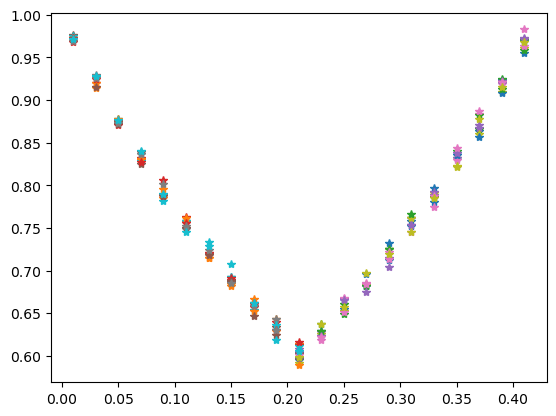

In [24]:
for i in range(10):
    plt.plot(tlist2[Ran],tevol_sim[i],'*')
    #plt.plot(tlist2[Ran],tevol[i],'*')
    plt.plot(tlist[Ran],tevolpre[i],'*')

In [25]:
ics = 0
for stat in range(simulNum):
    ics1,lamb = get_results_NCP_double_XY(sigXvals[8*stat+0],sigXvals[stat+1],sigXvals[8*stat+2],sigXvals[8*stat+3],lambs[-1],nshots)
    ics2,lamb = get_results_NCP_double_XY(sigXvals[8*stat+4],sigXvals[8*stat+5],sigXvals[8*stat+6],sigXvals[8*stat+7],lambs[-1],nshots)
    ics = ics + 0.5*(ics1 + ics2)

ics = ics/10

print(ics)

-0.0032799251524186133


In [26]:
ips = 0
for stat in range(simulNum):
    ips1,lamb = get_results_NCP_double_XY(sigYvals[8*stat+0],sigYvals[stat+1],sigYvals[8*stat+2],sigYvals[8*stat+3],lambs[-1],nshots)
    ips2,lamb = get_results_NCP_double_XY(sigYvals[8*stat+4],sigYvals[8*stat+5],sigYvals[8*stat+6],sigYvals[8*stat+7],lambs[-1],nshots)
    ips = ips + 0.5*(ips1 + ips2)

ips = ips/10

print(ips)

0.003941486260736095


In [27]:
zet = 0
for stat in range(simulNum):
    zet = zet + tevol_sim[stat,-1]
    
zet = zet/10

print(zet)

0.967424671989999


In [28]:
"""
zet = 0
for stat in range(simulNum):
    zet = zet + tevol[stat,-1]
    
zet = zet/10

print(zet)
"""

'\nzet = 0\nfor stat in range(simulNum):\n    zet = zet + tevol[stat,-1]\n    \nzet = zet/10\n\nprint(zet)\n'

In [29]:
rhoinit = np.matrix([[1,0],[0,0]])

ide = np.matrix([[1,0],[0,1]])
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])
rhon = 0.5*(ide + ics*s1 + ips*s2 + zet*s3)

fid_meas(rhoinit,rhon)*100

98.37123359949996

In [30]:
fid_meas2(rhoinit,rhon)

98.37123359949996

In [31]:
rhon

matrix([[ 0.98371234+0.j        , -0.00163996-0.00197074j],
        [-0.00163996+0.00197074j,  0.01628766+0.j        ]])

In [ ]:
#Backward evolution, no fidelity measure, older version (still working)

In [15]:
#Backward evolution, no fidelity measure

#Last changes: transpilation added to simulations too, as got needed; added binary probabilities property to the reading function, in case of simulation

simulation = 'yes'
jj = 22
backend = lima
dynamics = 'thermal'

layoutCP = 0
layoutNCP = 0

if dynamics == 'non-mark':
  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)
if dynamics == 'thermal':
  TTplus, TTminus, TTplusD, TTminusD = TTpm_F(jj)

xg = 'no'

if np.sum(np.abs(TTminus))<0.0000001:
    [ChoiP1, ChoiP2] = ExtremalMaps(TTplusD-TTminusD)
    KrausP11, KrausP12, UP11, UP12, mu1, nu1, sigma1 = KrausAndRotations(ChoiP1) #K0, K1, Uphi, Udel / 1st extremal
    KrausP21, KrausP22, UP21, UP22, mu2, nu2, sigma2 = KrausAndRotations(ChoiP2) ##K0, K1, Uphi, Udel / 2nd extremal
    expectt = spre(sigmap()*sigmam())
    lamb = 0

    qc1 = QAlgo_creation(mu1,nu1,xg,UP11,UP12,simulation='yes',precirc='yes')
    qc2 = QAlgo_creation(mu2,nu2,xg,UP21,UP22,simulation='yes',precirc='yes')

else:
    print('Map is not CP')


Ran = [1,3,5,7,9,11,13,15,17,19,21]         #,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50,55,60,65,70
nshots = 10000
NCPindex = []
qcs = []
nshotss = []
lambs = []
simulNum = 10

xg = 'no'

for stat in range(simulNum):
    print("Now running run number ", stat+1)
    for kk in range(len(Ran)):

        jj = Ran[kk]

        #if dynamics == 'non-mark':
        #  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)
        #if dynamics == 'thermal':
        #  TTplus, TTminus, TTplusD, TTminusD = TTpm(jj)

        TTplus, TTminus, TTplusD, TTminusD = TTpm(jj) #TTpm in any case, 'cos we move backwards

        if np.sum(np.abs(TTminus))<0.0000001:
            NCPindex.append('CP')
            [ChoiP1, ChoiP2] = ExtremalMaps(TTplusD-TTminusD)
            KrausP11, KrausP12, UP11, UP12, mu1, nu1, sigma1 = KrausAndRotations(ChoiP1) #K0, K1, Uphi, Udel / 1st extremal
            KrausP21, KrausP22, UP21, UP22, mu2, nu2, sigma2 = KrausAndRotations(ChoiP2) ##K0, K1, Uphi, Udel / 2nd extremal
            expectt = spre(sigmap()*sigmam())
            lamb = 0
            lambs.append(lamb)

            qca = QAlgo_creation(mu1,nu1,xg,UP11,UP12)
            qcb = QAlgo_creation(mu2,nu2,xg,UP21,UP22)

            # We create the quantum circuits
            nQubits = 3
            nReg = 3

            q1a = QuantumRegister(nQubits, name='q1a')
            c1a = ClassicalRegister(nReg, name='c1a')
            q1b = QuantumRegister(nQubits, name='q1b')
            c1b = ClassicalRegister(nReg, name='c1b')
            q2a = QuantumRegister(nQubits, name='q2a')
            c2a = ClassicalRegister(nReg, name='c2a')
            q2b = QuantumRegister(nQubits, name='q2b')
            c2b = ClassicalRegister(nReg, name='c2b')

            qc1a = QuantumCircuit(q1a)
            qc1a.add_register(c1a)
            qc1b = QuantumCircuit(q1b)
            qc1b.add_register(c1b)
            qc2a = QuantumCircuit(q2a)
            qc2a.add_register(c2a)
            qc2b = QuantumCircuit(q2b)
            qc2b.add_register(c2b)

            qc1a.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1b.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2a.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2b.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)

            ##################################################################
            if simulation == 'no':
              [qc1a,layoutCP],[qc1b,layoutCP],[qc2a,layoutCP],[qc2b,layoutCP] = opt_circuit(qc1a,backend),opt_circuit(qc1b,backend),opt_circuit(qc2a,backend),opt_circuit(qc2b,backend)
            if simulation == 'yes':
              qc1a = transpile(qc1a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1b = transpile(qc1b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc2a = transpile(qc2a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2b = transpile(qc2b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
            ##################################################################

            qcs.append(qc1a),qcs.append(qc1b),qcs.append(qc2a),qcs.append(qc2b)
            nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2)),nshotss.append(int(nshots/2))
            print(layoutCP, 'CP')

        else:
            NCPindex.append('NCP')
            ChoiM1, ChoiM2, ChoiP1, ChoiP2, lamb = extr_maps(TTminusD,TTplusD)
            lambs.append(lamb)

            #Compute the 4 pairs of Kraus operators 
            KrausM11, KrausM12, UM11, UM12, muM1, nuM1, sigma1 = KrausAndRotations(ChoiM1)
            KrausM21, KrausM22, UM21, UM22, muM2, nuM2, sigma2 = KrausAndRotations(ChoiM2)
            KrausP11, KrausP12, UP11, UP12, muP1, nuP1, sigma3 = KrausAndRotations(ChoiP1)
            KrausP21, KrausP22, UP21, UP22, muP2, nuP2, sigma4 = KrausAndRotations(ChoiP2)

            sh1 = int((nshots/2)*lamb/(1+2*lamb))
            sh2 = int(nshots/2-sh1)

            qca = QAlgo_creation(muM1,nuM1,xg,UM11,UM12)
            qcb = QAlgo_creation(muM2,nuM2,xg,UM21,UM22)
            qcc = QAlgo_creation(muP1,nuP1,xg,UP11,UP12)
            qcd = QAlgo_creation(muP2,nuP2,xg,UP21,UP22)

            # We create the quantum circuits
            nQubits = 3
            nReg = 3

            q1a = QuantumRegister(nQubits, name='q1a')
            c1a = ClassicalRegister(nReg, name='c1a')
            q1b = QuantumRegister(nQubits, name='q1b')
            c1b = ClassicalRegister(nReg, name='c1b')
            q1c = QuantumRegister(nQubits, name='q1c')
            c1c = ClassicalRegister(nReg, name='c1c')
            q1d = QuantumRegister(nQubits, name='q1d')
            c1d = ClassicalRegister(nReg, name='c1d')
            q2a = QuantumRegister(nQubits, name='q2a')
            c2a = ClassicalRegister(nReg, name='c2a')
            q2b = QuantumRegister(nQubits, name='q2b')
            c2b = ClassicalRegister(nReg, name='c2b')
            q2c = QuantumRegister(nQubits, name='q2c')
            c2c = ClassicalRegister(nReg, name='c2c')
            q2d = QuantumRegister(nQubits, name='q2d')
            c2d = ClassicalRegister(nReg, name='c2d')

            qc1a = QuantumCircuit(q1a)
            qc1a.add_register(c1a)
            qc1b = QuantumCircuit(q1b)
            qc1b.add_register(c1b)
            qc1c = QuantumCircuit(q1c)
            qc1c.add_register(c1c)
            qc1d = QuantumCircuit(q1d)
            qc1d.add_register(c1d)
            qc2a = QuantumCircuit(q2a)
            qc2a.add_register(c2a)
            qc2b = QuantumCircuit(q2b)
            qc2b.add_register(c2b)
            qc2c = QuantumCircuit(q2c)
            qc2c.add_register(c2c)
            qc2d = QuantumCircuit(q2d)
            qc2d.add_register(c2d)

            qc1a.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1b.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1c.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1c.compose(qcc, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc1d.compose(qc1, qubits=[0, 1], clbits=[1, 2], inplace=True), qc1d.compose(qcd, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2a.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2a.compose(qca, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2b.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2b.compose(qcb, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2c.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2c.compose(qcc, qubits=[0, 2], clbits=[0, 2], inplace=True)
            qc2d.compose(qc2, qubits=[0, 1], clbits=[1, 2], inplace=True), qc2d.compose(qcd, qubits=[0, 2], clbits=[0, 2], inplace=True)

            ##################################################################
            if simulation == 'no':  
              [qc1a,layoutNCP],[qc1b,layoutNCP],[qc1c,layoutNCP],[qc1d,layoutNCP] = opt_circuit(qc1a,backend),opt_circuit(qc1b,backend),opt_circuit(qc1c,backend),opt_circuit(qc1d,backend)
              [qc2a,layoutNCP],[qc2b,layoutNCP],[qc2c,layoutNCP],[qc2d,layoutNCP] = opt_circuit(qc2a,backend),opt_circuit(qc2b,backend),opt_circuit(qc2c,backend),opt_circuit(qc2d,backend)
            if simulation == 'yes':
              qc1a = transpile(qc1a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1b = transpile(qc1b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc1c = transpile(qc1c, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc1d = transpile(qc1d, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0) 
              qc2a = transpile(qc2a, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2b = transpile(qc2b, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)        
              qc2c = transpile(qc2c, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)
              qc2d = transpile(qc2d, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level=0)  
            ##################################################################

            qcs.append(qc1a),qcs.append(qc1b),qcs.append(qc1c),qcs.append(qc1d),qcs.append(qc2a),qcs.append(qc2b),qcs.append(qc2c),qcs.append(qc2d)
            nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh1),nshotss.append(sh2),nshotss.append(sh2),nshotss.append(sh2),nshotss.append(sh2)
            print(layoutNCP, 'NCP')

        print(kk)
    

if simulation == 'yes':    
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    #resilience_settings = {"level":0}  
    circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist()
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_qasm_simulator" }) as sampler:
    #    # pass indices of circuits
    #    mitigated_probs = sampler(circuits=circlist,shots=nshots)
    #    mitigated_probs = mitigated_probs.quasi_dists

    with Session(service=service, backend = "ibmq_qasm_simulator"):
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        mitigated_probs = job.result().quasi_dists

        
elif simulation == 'no':
    start_time = time.time()

########################################################
  #qubitss = measurement_layout(qcs[0])
    if layoutNCP == 0:
        exp = LocalReadoutError(layoutCP)
    else:
        exp = LocalReadoutError(layoutNCP)
    
    exp.run_options.__dict__['shots']=10000
  
    print("RUNNING 1!")
    result = exp.run(backend)
    #print(result.assignment_matrix())
    #mitigator = LocalReadoutMitigator(assignment_matrices=result.assignment_matrix()) 
    mitigator = result.analysis_results(0).value
########################################################
      
    options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
    circlist = np.linspace(0,len(nshotss)-1,len(nshotss),dtype=int).tolist() 
    #resilience_settings = {"level":0}
    samples_with_rem = None
    
    print("RUNNING 2!")
    #with Sampler(circuits=qcs, service=service, options={ "backend": "ibmq_ehningen" }) as sampler:    # "ibmq_qasm_simulator", "ibm_geneva", "ibmq_toronto"
    #    # pass indices of circuits
    #    countings = sampler(circuits=circlist,shots=nshots)         
    with Session(service=service, backend = "ibmq_lima"): #ibmq_quito ibmq_ehningen
        sampler = Sampler(options=options)
        job = sampler.run(circuits=qcs)
        countings = job.result().quasi_dists

        
    mitigated_probs = []
    for i in range(len(countings)):  
        mitigated_quasi_probs = mitigator.quasi_probabilities(countings[i].binary_probabilities()) #may be negative
        mitigated_probs.append(mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

Now running run number  1
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  2
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  3
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  4
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  5
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  6
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  7
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  8
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP
6
0 NCP
7
0 NCP
8
0 NCP
9
0 NCP
10
Now running run number  9
0 NCP
0
0 NCP
1
0 NCP
2
0 NCP
3
0 NCP
4
0 NCP
5
0 NCP


In [16]:
xj = 0
tevol = np.zeros((simulNum,len(Ran)))
tevol1 = np.zeros((simulNum,len(Ran)))
tevol2 = np.zeros((simulNum,len(Ran)))

if simulation == 'yes':
    for kj in range(len(mitigated_probs)):
        mitigated_probs[kj] = mitigated_probs[kj].binary_probabilities()

for stat in range(simulNum):
    for kk in range(len(Ran)):
        if NCPindex[kk] == 'CP':
            tevol1[stat,kk] = get_results_CP_double(mitigated_probs[xj],mitigated_probs[xj+1])
            tevol2[stat,kk] = get_results_CP_double(mitigated_probs[xj+2],mitigated_probs[xj+3])
            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+4
            #print('CP')

        else:
            tevol1[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj],mitigated_probs[xj+1],mitigated_probs[xj+2],mitigated_probs[xj+3],lambs[kk],nshots)
            tevol2[stat,kk],lamb = get_results_NCP_double(mitigated_probs[xj+4],mitigated_probs[xj+5],mitigated_probs[xj+6],mitigated_probs[xj+7],lambs[kk],nshots)
            tevol[stat,kk] = 0.5*(tevol1[stat,kk] + tevol2[stat,kk])
            xj = xj+8
            #print('NCP')
            
print('Done')

#np.savetxt('/content/drive/MyDrive/Colab Notebooks/tevol_startmiddle_normal2.gz', tevol)

Done


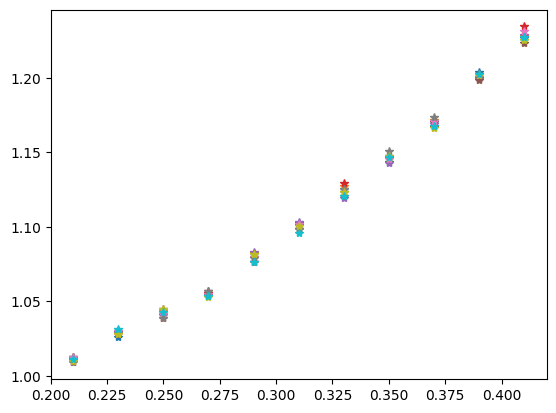

In [177]:
#Store data in a proper way to plot

brechtlayoutMult(tlist2,Ran,tevol,'Thermal_1_NCP')
tttry = np.loadtxt('Thermal_1_NCP.txt')

tlistt = []
tevoll = []

for i in range(simulNum):
    tlistt.append(tttry[i*len(tlist[Ran]):(i+1)*len(tlist[Ran]),0]) 
    tevoll.append(tttry[i*len(tlist[Ran]):(i+1)*len(tlist[Ran]),1])
    
tlistt = tlistt[0]
    
    
for i in range(simulNum):
    plt.plot(tlistt,tevoll[i],'*') 

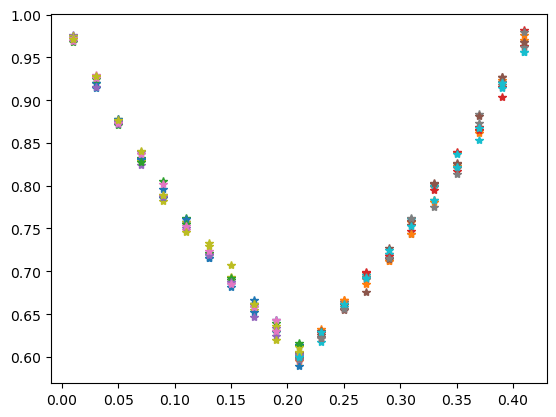

In [17]:
for i in range(simulNum):
    plt.plot(tlist[Ran],tevolpre[i],'*')
    plt.plot(tlist2[Ran],tevol[i],'*')

In [ ]:
########## OLD CODE ###########


def get_results_CP_light_reverse(counts1,counts2): #Here I run the circuits for the CP case and then combine the countings to evaluate the dynamics of the system.

    try:
        elvn1 = counts1['00']
    except:
        elvn1 = 0
    try:
        zon1 = counts1['10']
    except:
        zon1 = 0
        
    try:
        elvn2 = counts2['00']
    except:
        elvn2 = 0
    try:
        zon2 = counts2['10']
    except:
        zon2 = 0

    mea1 = zon1 + elvn1
    mea2 = zon2 + elvn2
    measure = zon1 + zon2 + elvn1 + elvn2
    
    return measure/2


def get_results_CP_double_reverse(counts1,counts2): #Here I run the circuits for the CP case and then combine the countings to evaluate the dynamics of the system.

    try:
        elvn1 = counts1['000']
    except:
        elvn1 = 0
    try:
        elvn2 = counts1['100']
    except:
        elvn2 = 0
    try:
        elvn3 = counts1['010']
    except:
        elvn3 = 0
    try:
        elvn4 = counts1['110']
    except:
        elvn4 = 0

    try:
        elvn5 = counts2['000']
    except:
        elvn5 = 0
    try:
        elvn6 = counts2['100']
    except:
        elvn6 = 0
    try:
        elvn7 = counts2['010']
    except:
        elvn7 = 0
    try:
        elvn8 = counts2['110']
    except:
        elvn8 = 0

    mea1 = elvn1 + elvn2 + elvn3 + elvn4
    mea2 = elvn5 + elvn6 + elvn7 + elvn8

    measure = mea1 + mea2
    
    return measure/2




def get_results_NCP_light_reverse(counts1,counts2,counts3,counts4,lamb,nshots): #Here I run the circuits for the Non-CP case and then combine the countings to evaluate the dynamics of the system. This might be investigated better maybe?

    sh1 = int((nshots/2)*lamb/(1+2*lamb))
    sh2 = int(nshots/2-sh1)

    if sh1 != 0:
        try:
            elvn1 = counts1['00']
        except:
            elvn1 = 0
        try:
            zon1 = counts1['10']
        except:
            zon1 = 0


        try:
            elvn2 = counts2['00']
        except:
            elvn2 = 0
        try:
            zon2 = counts2['10']
        except:
            zon2 = 0
            
        mea1 = zon1 + elvn1
        mea2 = zon2 + elvn2
        measure1 = (zon1 + zon2 + elvn1 + elvn2)*sh1/nshots

    else: 
        measure1 = 0

    try:
        elvn3 = counts3['00']
    except:
        elvn3 = 0
    try:
        zon3 = counts3['10']
    except:
        zon3 = 0

    try:
        elvn4 = counts4['00']
    except:
        elvn4 = 0
    try:
        zon4 = counts4['10']
    except:
        zon4 = 0
        
    mea3 = zon3 + elvn3
    mea4 = zon4 + elvn4
    measure2 = (zon3 + zon4 + elvn3 + elvn4)*sh2/nshots    
    evalu = (measure2*(1+2*lamb) - measure1*(1+2*lamb))

    return evalu, lamb


def get_results_NCP_double_reverse(counts1,counts2,counts3,counts4,lamb,nshots): #Here I run the circuits for the Non-CP case and then combine the countings to evaluate the dynamics of the system. This might be investigated better maybe?

    sh1 = int((nshots/2)*lamb/(1+2*lamb))
    sh2 = int(nshots/2-sh1)

    if sh1 != 0:
        try:
            elvn1 = counts1['000']
        except:
            elvn1 = 0
        try:
            elvn2 = counts1['100']
        except:
            elvn2 = 0
        try:
            elvn3 = counts1['010']
        except:
            elvn3 = 0
        try:
            elvn4 = counts1['110']
        except:
            elvn4 = 0

        try:
            elvn5 = counts2['000']
        except:
            elvn5 = 0
        try:
            elvn6 = counts2['100']
        except:
            elvn6 = 0
        try:
            elvn7 = counts2['010']
        except:
            elvn7 = 0
        try:
            elvn8 = counts2['110']
        except:
            elvn8 = 0

        mea1 = elvn1 + elvn2 + elvn3 + elvn4
        mea2 = elvn5 + elvn6 + elvn7 + elvn8
        measure1 = (mea1 + mea2)*sh1/nshots

    else: 
        measure1 = 0

    try:
        alvn1 = counts3['000']
    except:
        alvn1 = 0
    try:
        alvn2 = counts3['100']
    except:
        alvn2 = 0
    try:
        alvn3 = counts3['010']
    except:
        alvn3 = 0
    try:
        alvn4 = counts3['110']
    except:
        alvn4 = 0

    try:
        alvn5 = counts4['000']
    except:
        alvn5 = 0
    try:
        alvn6 = counts4['100']
    except:
        alvn6 = 0
    try:
        alvn7 = counts4['010']
    except:
        alvn7 = 0
    try:
        alvn8 = counts4['110']
    except:
        alvn8 = 0

    mea3 = alvn1 + alvn2 + alvn3 + alvn4
    mea4 = alvn5 + alvn6 + alvn7 + alvn8
    measure2 = (mea3 + mea4)*sh2/nshots
    evalu = (measure2*(1+2*lamb) - measure1*(1+2*lamb))

    return evalu, lamb